## Code of Homework Assignment 2

### Import libraries

In [1]:
# -*- coding: utf-8 -*-
import lxml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow
import requests
import tabulate
import yfinance as yf
from io import StringIO
import gdown
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from watermark import watermark

%load_ext watermark

In [2]:
%watermark --iversions

gdown     : 5.2.0
pyarrow   : 20.0.0
lxml      : 5.4.0
numpy     : 2.3.1
sklearn   : 1.7.0
matplotlib: 3.10.3
yfinance  : 0.2.63
watermark : 2.5.0
pandas    : 2.3.0
requests  : 2.32.4
tabulate  : 0.9.0



In [3]:
print(watermark())

Last updated: 2025-06-24T00:17:39.683747+03:00

Python implementation: CPython
Python version       : 3.12.0
IPython version      : 9.3.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit



## Question 1: [IPO] Withdrawn IPOs by Company Type
What is the total withdrawn IPO value (in $ millions) for the company class with the highest total withdrawal value?


In [4]:
# Load the IPO withdrawal table into a DataFrame
def get_withdrawn_ipos() -> pd.DataFrame:
    """
    Fetch IPO data for the given year from stockanalysis.com.
    """
    url = 'https://stockanalysis.com/ipos/withdrawn/'
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/58.0.3029.110 Safari/537.3'
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Wrap HTML text in StringIO to avoid deprecation warning
        # "Passing literal html to 'read_html' is deprecated and will be removed in a future version.
        # To read from a literal string, wrap it in a 'StringIO' object."
        html_io = StringIO(response.text)
        tables = pd.read_html(html_io)

        if not tables:
            raise ValueError(f"No tables found for year {year}.")

        return tables[0]

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Data error: {ve}")
    except Exception as ex:
        print(f"Unexpected error: {ex}")

    return pd.DataFrame()

# Function to categorize company names into Company Class
def categorize_company_class(name):
    name = name.lower()
    words = name.split()

    if any(pattern in words for pattern in ["acquisition", "corp"]):
        return "Acq.Corp"
    elif any(pattern in words for pattern in ["inc", "incorporated"]):
        return "Inc"
    elif "group" in words:
        return "Group"
    elif any(pattern in words for pattern in ["ltd", "limited"]):
        return "Limited"
    elif "holdings" in words:
        return "Holdings"
    else:
        return "Other"

# Function to calculate average price from Price Range
def calculate_avg_price(price_range):
    if price_range == '-':
        return None
    try:
        prices = price_range.replace('$', '').split('-')
        if len(prices) == 1:
            return float(prices[0])
        else:
            low, high = float(prices[0]), float(prices[1].strip())
            return (low + high) / 2
    except Exception as e:
        print(f"Failed to parse price range: {price_range}, error: {e}")
        return None

# Function to clean and convert Shares Offered to numeric
def clean_shares_offered_old(shares):
    try:
        return int(shares.replace(',', ''))
    except Exception as e:
        print(f"Failed to convert shares offered: {shares}, error: {e}")
        return np.nan

# Function to clean and convert Shares Offered to numeric
def clean_shares_offered(shares):
  try:
    if shares in ['-', '', 'N/A', np.nan]:
      return np.nan

    return int(shares.replace(',', ''))
  except Exception as e:
      print(f"Failed to convert shares offered: {shares}, error: {e}")
      return np.nan

# Main function to process data and find the company class with the highest total withdrawal value
def process_data() -> pd.DataFrame:
    
    # Load data
    df = get_withdrawn_ipos()
    
    if df is None:
        print("Failed to load data.")
        return pd.DataFrame()

    # Ensure we have the correct number of entries
    assert len(df) <= 100, f"Expected less than 100 entries, but got {len(df)}"

    # Categorize company names
    df['Company Class'] = df['Company Name'].apply(categorize_company_class)

    # Calculate average price
    df['Avg Price'] = df['Price Range'].apply(calculate_avg_price)

    # Clean Shares Offered
    df['Shares Offered'] = df['Shares Offered'].apply(clean_shares_offered)

    # Calculate Withdrawn Value
    df['Withdrawn Value'] = df['Shares Offered'] * df['Avg Price']

    # Group by Company Class and calculate total withdrawn value
    total_withdrawn_values = df.groupby('Company Class')['Withdrawn Value'].sum().reset_index()

    # Find the company class with the highest total withdrawal value
    max_withdrawn_class = total_withdrawn_values.loc[total_withdrawn_values['Withdrawn Value'].idxmax()]

    print(f"The company class with the highest total withdrawal value is: {max_withdrawn_class['Company Class']}")
    print(f"Total withdrawn value: ${max_withdrawn_class['Withdrawn Value'] / 1e6:.2f} million")

    return df

df = process_data()

The company class with the highest total withdrawal value is: Acq.Corp
Total withdrawn value: $4021.00 million


### Verification of output

In [5]:
df

,Symbol,Company Name,Price Range,Shares Offered,Company Class,Avg Price,Withdrawn Value
0,ODTX,"Odyssey Therapeutics, Inc.",-,NaN,Other,NaN,NaN
1,UNFL,"Unifoil Holdings, Inc.",$3.00 - $4.00,2000000.0,Other,3.5,7000000.0
2,AURN,"Aurion Biotech, Inc.",-,NaN,Other,NaN,NaN
3,ROTR,"PHI Group, Inc.",-,NaN,Other,NaN,NaN
4,ONE,One Power Company,-,NaN,Other,NaN,NaN
...,...,...,...,...,...,...,...
95,FHP,"Freehold Properties, Inc.",-,NaN,Other,NaN,NaN
96,CHO,Chobani Inc.,-,NaN,Other,NaN,NaN
97,IFIT,iFIT Health & Fitness Inc.,$18.00 - $21.00,30769231.0,Other,19.5,600000004.5
98,GLGX,"Gerson Lehrman Group, Inc.",-,NaN,Other,NaN,NaN


In [6]:
df.groupby('Company Class')['Withdrawn Value'].sum().sort_values(ascending=False).reset_index()

,Company Class,Withdrawn Value
0,Acq.Corp,4.021000e+09
1,Other,3.035842e+09
2,Limited,5.035346e+08
3,Holdings,8.000000e+07
4,Group,6.423005e+07


## Question 2: [IPO] Median Sharpe Ratio for 2024 IPOs (First 5 Months)
What is the median Sharpe ratio (as of 6 June 2025) for companies that went public in the first 5 months of 2024?

In [7]:
url = f"https://stockanalysis.com/ipos/2024/"
headers = {
    'User-Agent': (
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
        'AppleWebKit/537.36 (KHTML, like Gecko) '
        'Chrome/58.0.3029.110 Safari/537.3'
    )
}


response = requests.get(url, headers=headers, timeout=10)
response.raise_for_status()

# Wrap HTML text in StringIO to avoid deprecation warning
# "Passing literal html to 'read_html' is deprecated and will be removed in a future version.
# To read from a literal string, wrap it in a 'StringIO' object."
html_io = StringIO(response.text)
tables = pd.read_html(html_io)


In [8]:
df = tables[0]
df.head()

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,"Dec 31, 2024",ONEG,OneConstruction Group Limited,$4.00,$5.30,25.00%
1,"Dec 27, 2024",PHH,"Park Ha Biological Technology Co., Ltd.",$4.00,$30.11,632.75%
2,"Dec 23, 2024",HIT,"Health In Tech, Inc.",$4.00,$0.66,-84.40%
3,"Dec 23, 2024",TDAC,Translational Development Acquisition Corp.,$10.00,$10.27,2.70%
4,"Dec 20, 2024",RANG,Range Capital Acquisition Corp.,$10.00,$10.20,2.00%


In [9]:
df['IPO Date'] = pd.to_datetime(df['IPO Date'])
df_filtered = df[df['IPO Date'] <= '2024-05-31']
df_filtered.shape

(77, 6)

In [10]:
df_filtered

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
148,2024-05-31,NAKA,"Kindly MD, Inc.",-,$16.30,-
149,2024-05-23,BOW,Bowhead Specialty Holdings Inc.,$17.00,$37.25,120.59%
150,2024-05-17,HDL,Super Hi International Holding Ltd.,$19.56,$18.70,-4.40%
151,2024-05-17,RFAI,RF Acquisition Corp II,$10.00,$10.59,6.00%
152,2024-05-15,JDZG,JIADE Limited,$4.00,$0.26,-93.50%
...,...,...,...,...,...,...
220,2024-01-18,CCTG,CCSC Technology International Holdings Limited,$6.00,$1.07,-82.17%
221,2024-01-18,PSBD,Palmer Square Capital BDC Inc.,$16.45,$14.77,-10.82%
222,2024-01-12,SYNX,Silynxcom Ltd.,$4.00,$1.95,-48.25%
223,2024-01-11,SDHC,Smith Douglas Homes Corp.,$21.00,$18.40,-13.38%


In [11]:
ticker_obj = yf.Ticker("ROMA")
nvo_df = ticker_obj.history(period = "max", interval = "1d")

In [12]:
nvo_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-01-09 00:00:00-05:00,10.000,11.8000,2.90,2.900,4601100,0.0,0.0
2024-01-10 00:00:00-05:00,2.430,5.6300,2.30,3.950,25792300,0.0,0.0
2024-01-11 00:00:00-05:00,4.180,6.7300,3.95,4.040,40416900,0.0,0.0
2024-01-12 00:00:00-05:00,4.700,4.9000,3.76,4.030,4865400,0.0,0.0
2024-01-16 00:00:00-05:00,3.660,3.9100,3.25,3.910,946500,0.0,0.0
...,...,...,...,...,...,...,...
2025-06-16 00:00:00-04:00,2.840,3.0000,2.64,2.875,63100,0.0,0.0
2025-06-17 00:00:00-04:00,2.850,2.9350,2.79,2.795,10200,0.0,0.0
2025-06-18 00:00:00-04:00,2.883,2.9000,2.73,2.790,33600,0.0,0.0


In [13]:
def growth_252d_series(historyPrices, ticker):
  """
  Generate features for historical prices and what we want to predict.
  """


  # ensure the DataFrame is sorted by date
  historyPrices = historyPrices.sort_index()
  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # historical returns
  for i in [1,30, 252]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Close'] / historyPrices['Close'].shift(i)
  historyPrices['growth_future_30d'] = historyPrices['Close'].shift(-30) / historyPrices['Close']
  historyPrices['volatility'] =   historyPrices['Close'].rolling(30).std() * np.sqrt(252)
  historyPrices['Sharpe'] = (historyPrices['growth_252d'] - 0.045) / historyPrices['volatility']

  return historyPrices


prices = growth_252d_series(nvo_df, "ROMA")
prices

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,Weekday,Date,growth_1d,growth_30d,growth_252d,growth_future_30d,volatility,Sharpe
Date,,,,,,,,,,,,,,,,,,
2024-01-09 00:00:00-05:00,10.000,11.8000,2.90,2.900,4601100,0.0,0.0,ROMA,2024,1,1,2024-01-09,NaN,NaN,NaN,0.631034,NaN,NaN
2024-01-10 00:00:00-05:00,2.430,5.6300,2.30,3.950,25792300,0.0,0.0,ROMA,2024,1,2,2024-01-10,1.362069,NaN,NaN,0.410127,NaN,NaN
2024-01-11 00:00:00-05:00,4.180,6.7300,3.95,4.040,40416900,0.0,0.0,ROMA,2024,1,3,2024-01-11,1.022785,NaN,NaN,0.346535,NaN,NaN
2024-01-12 00:00:00-05:00,4.700,4.9000,3.76,4.030,4865400,0.0,0.0,ROMA,2024,1,4,2024-01-12,0.997525,NaN,NaN,0.287841,NaN,NaN
2024-01-16 00:00:00-05:00,3.660,3.9100,3.25,3.910,946500,0.0,0.0,ROMA,2024,1,1,2024-01-16,0.970223,NaN,NaN,0.309463,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-16 00:00:00-04:00,2.840,3.0000,2.64,2.875,63100,0.0,0.0,ROMA,2025,6,0,2025-06-16,1.080827,1.955782,5.424529,NaN,9.939668,0.541218
2025-06-17 00:00:00-04:00,2.850,2.9350,2.79,2.795,10200,0.0,0.0,ROMA,2025,6,1,2025-06-17,0.972174,1.814935,5.008960,NaN,9.469241,0.524219
2025-06-18 00:00:00-04:00,2.883,2.9000,2.73,2.790,33600,0.0,0.0,ROMA,2025,6,2,2025-06-18,0.998211,1.516304,5.157116,NaN,9.196931,0.555850


In [14]:
prices.dropna(inplace=True)
prices.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Year,Month,Weekday,growth_1d,growth_30d,growth_252d,growth_future_30d,volatility,Sharpe
count,82.000000,82.000000,82.000000,82.000000,8.200000e+01,82.0,82.0,82.0,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,0.839122,0.898366,0.807988,0.858927,5.795000e+04,0.0,0.0,2025.0,2.804878,2.024390,1.015114,1.184437,0.908948,1.773522,1.261653,0.731049
std,0.266615,0.324358,0.246634,0.294093,1.235419e+05,0.0,0.0,0.0,1.221606,1.396429,0.062974,0.388306,0.555713,0.711446,0.939822,0.236185
min,0.620000,0.660000,0.580000,0.580000,8.000000e+02,0.0,0.0,2025.0,1.000000,0.000000,0.784314,0.725000,0.166240,0.906344,0.630329,0.107500
25%,0.680000,0.730000,0.651250,0.684750,7.900000e+03,0.0,0.0,2025.0,2.000000,1.000000,0.985314,0.912495,0.576434,1.149754,0.750178,0.632862
50%,0.749500,0.767500,0.700000,0.755000,2.635000e+04,0.0,0.0,2025.0,3.000000,2.000000,1.011040,1.112664,0.754245,1.481612,0.878965,0.723592
75%,0.932500,0.970000,0.895500,0.955000,5.927500e+04,0.0,0.0,2025.0,4.000000,3.000000,1.033124,1.357969,1.054805,2.454535,1.211792,0.869369
max,2.060000,2.580000,1.820000,2.020000,1.032400e+06,0.0,0.0,2025.0,5.000000,4.000000,1.194805,2.657895,2.902299,3.387387,5.489688,1.109157


In [15]:
# Load the IPO list for 2024 into a DataFrame
def get_ipos_by_year(year: int) -> pd.DataFrame:
    """
    Fetch IPO data for the given year from stockanalysis.com.
    """
    url = f"https://stockanalysis.com/ipos/{year}/"
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/58.0.3029.110 Safari/537.3'
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Wrap HTML text in StringIO to avoid deprecation warning
        # "Passing literal html to 'read_html' is deprecated and will be removed in a future version.
        # To read from a literal string, wrap it in a 'StringIO' object."
        html_io = StringIO(response.text)
        tables = pd.read_html(html_io)

        if not tables:
            raise ValueError(f"No tables found for year {year}.")

        return tables[0]

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Data error: {ve}")
    except Exception as ex:
        print(f"Unexpected error: {ex}")

    return pd.DataFrame()

# Function to download daily stock data for tickers
def download_stock_data(tickers):
  stocks_df = pd.DataFrame()

  for ticker in tickers:

    ticker_obj = yf.Ticker(ticker)
    
    try:
      data = ticker_obj.history(period = "max", interval = "1d")
      data['Ticker'] = ticker

      data = calculate_growth_volatility(data, ticker)
      stocks_df = pd.concat([stocks_df, data])

      
    except Exception as e:
      print(f"Failed to download data for {ticker}: {e}")
    
  return stocks_df

# Function to calculate growth and volatility
def calculate_growth_volatility_(stocks_df):
  stocks_df['growth_1d'] = stocks_df.groupby('Ticker')['Close'].pct_change()
  #stocks_df['growth_5d'] = stocks_df.groupby('Ticker')['Close'].pct_change(5)
  #stocks_df['growth_21d'] = stocks_df.groupby('Ticker')['Close'].pct_change(21)
  #stocks_df['growth_63d'] = stocks_df.groupby('Ticker')['Close'].pct_change(63)
  #stocks_df['growth_126d'] = stocks_df.groupby('Ticker')['Close'].pct_change(126)
  stocks_df['growth_252d'] = stocks_df.groupby('Ticker')['Close'].pct_change(252)

  # Original volatility calculation
  stocks_df['volatility'] = stocks_df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(30).std() * np.sqrt(252))
  return stocks_df

def calculate_growth_volatility(historyPrices, ticker):
  """
  Generate features for historical prices and what we want to predict.
  """
  # ensure the DataFrame is sorted by date
  historyPrices = historyPrices.sort_index()
  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # historical returns
  for i in [1,30,252]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Close'] / historyPrices['Close'].shift(i)
  historyPrices['growth_future_30d'] = historyPrices['Close'].shift(-30) / historyPrices['Close']
  historyPrices['volatility'] =   historyPrices['Close'].rolling(30).std() * np.sqrt(252)
  historyPrices['Sharpe'] = (historyPrices['growth_252d'] - 0.045) / historyPrices['volatility']

  return historyPrices



# Function to calculate Sharpe ratio
def calculate_sharpe_ratio(stocks_df, risk_free_rate=0.045):
 stocks_df['Sharpe'] = (stocks_df['growth_252d'] - risk_free_rate) / stocks_df['volatility']
 return stocks_df

# Main function to process data and find median Sharpe ratio
def process_data(year: int = 2024):

  # Load data
  df = get_ipos_by_year(year=year)
  
  if df is None:
    return

  # Filter IPOs before 1 June 2024
  df['IPO Date'] = pd.to_datetime(df['IPO Date'])
  df_filtered = df[df['IPO Date'] <= '2024-05-31']
  #df_filtered = df_filtered.iloc[-75:]  # Get the last 75 IPOs
  tickers = df_filtered['Symbol'].tolist()
  print("tickers: ", tickers)

  # Download daily stock data
  stocks_df = download_stock_data(tickers)

  #print(stocks_df.head())
  print(stocks_df.shape)

  # Calculate growth and volatility
  #stocks_df = calculate_growth_volatility(stocks_df)

  # Calculate Sharpe ratio
  stocks_df = calculate_sharpe_ratio(stocks_df)

  # Filter data for the trading day '2025-06-06'
  stocks_df['Date'] = pd.to_datetime(stocks_df.index)
  stocks_df_filtered = stocks_df[stocks_df['Date'] == '2025-06-06']

  # Compute descriptive statistics
  growth_252d_series = stocks_df_filtered['growth_252d'].dropna()
  sharpe_series = stocks_df_filtered['Sharpe'].dropna()

  print("Descriptive statistics for growth_252d:")
  print(growth_252d_series.describe())

  print("\nDescriptive statistics for Sharpe:")
  print(sharpe_series.describe())

  # Median Sharpe ratio
  median_sharpe = sharpe_series.median()
  print(f"\nMedian Sharpe ratio: {median_sharpe:.4f}")

  return stocks_df


stocks_df = process_data()

tickers:  ['NAKA', 'BOW', 'HDL', 'RFAI', 'JDZG', 'RAY', 'BTOC', 'ZK', 'GPAT', 'PAL', 'SVCO', 'NNE', 'CCIX', 'VIK', 'ZONE', 'LOAR', 'MRX', 'RBRK', 'NCI', 'MFI', 'YYGH', 'TRSG', 'CDTG', 'CTRI', 'IBTA', 'MTEN', 'SUPX', 'TWG', 'ULS', 'PACS', 'MNDR', 'CTNM', 'MAMO', 'ZBAO', 'BOLD', 'MMA', 'UBXG', 'IBAC', 'AUNA', 'BKHA', 'LOBO', 'RDDT', 'ALAB', 'INTJ', 'RYDE', 'LGCL', 'SMXT', 'VHAI', 'DYCQ', 'CHRO', 'UMAC', 'HLXB', 'MGX', 'TBBB', 'TELO', 'KYTX', 'PMNT', 'AHR', 'LEGT', 'ANRO', 'GUTS', 'AS', 'FBLG', 'AVBP', 'BTSG', 'HAO', 'CGON', 'YIBO', 'JL', 'SUGP', 'JVSA', 'KSPI', 'CCTG', 'PSBD', 'SYNX', 'SDHC', 'ROMA']
(23954, 18)
Descriptive statistics for growth_252d:
count    73.000000
mean      1.227946
std       1.480238
min       0.024970
25%       0.293510
50%       0.763188
75%       1.446667
max       8.097413
Name: growth_252d, dtype: float64

Descriptive statistics for Sharpe:
count    73.000000
mean      0.284576
std       0.512601
min      -0.079677
25%       0.040265
50%       0.083768
75%   

In [16]:
stocks_df.shape

(23954, 18)

## Question 3: [IPO] ‘Fixed Months Holding Strategy’
What is the optimal number of months (1 to 12) to hold a newly IPO'd stock in order to maximize average growth?

In [17]:
# Load the IPO list for 2024 into a DataFrame
def get_ipos_by_year(year: int) -> pd.DataFrame:
    """
    Fetch IPO data for the given year from stockanalysis.com.
    """
    url = f"https://stockanalysis.com/ipos/{year}/"
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/58.0.3029.110 Safari/537.3'
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Wrap HTML text in StringIO to avoid deprecation warning
        # "Passing literal html to 'read_html' is deprecated and will be removed in a future version.
        # To read from a literal string, wrap it in a 'StringIO' object."
        html_io = StringIO(response.text)
        tables = pd.read_html(html_io)

        if not tables:
            raise ValueError(f"No tables found for year {year}.")

        return tables[0]

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Data error: {ve}")
    except Exception as ex:
        print(f"Unexpected error: {ex}")

    return pd.DataFrame()

# Function to download daily stock data for tickers
def download_stock_data(tickers):
  stocks_df = pd.DataFrame()

  for ticker in tickers:

    ticker_obj = yf.Ticker(ticker)
    
    try:
      data = ticker_obj.history(period = "max", interval = "1d")
      data['Ticker'] = ticker

      data = calculate_growth_future(data, ticker)
      stocks_df = pd.concat([stocks_df, data])

      
    except Exception as e:
      print(f"Failed to download data for {ticker}: {e}")
    
  return stocks_df


def calculate_growth_future(historyPrices, ticker):
  """
  Generate features for historical prices and what we want to predict.
  """
  # ensure the DataFrame is sorted by date
  historyPrices = historyPrices.sort_index()
  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # historical returns
  months = range(1, 13)
  for month in months:
    days = month * 21 # Assuming 1 month = 21 trading days
    #historyPrices['future_growth_'+str(month)+'m'] = historyPrices['Close'] / historyPrices['Close'].shift(days)
    historyPrices['future_growth_'+str(month)+'m'] = historyPrices['Close'].shift(-days) / historyPrices['Close']


  return historyPrices


# Function to determine the first trading day for each ticker
def get_first_trading_day(stocks_df):
    min_dates = stocks_df.groupby('Ticker')['Date'].min().reset_index()
    min_dates.columns = ['Ticker', 'first_trading_day']

    return min_dates

# Function to join data and compute descriptive statistics
def analyze_future_growth(stocks_df, min_dates):
    # Join data
    joined_df = pd.merge(
        stocks_df,
        min_dates,
        left_on=['Ticker', 'Date'],
        right_on=['Ticker', 'first_trading_day']
    )

    print(f"Joined DataFrame shape: {joined_df.shape}")

    return joined_df
    

In [18]:
df = get_ipos_by_year(year=2024)


# Filter IPOs before 1 June 2024
df['IPO Date'] = pd.to_datetime(df['IPO Date'])
df_filtered = df[df['IPO Date'] <= '2024-05-31']
#df_filtered = df_filtered.iloc[-75:]  # Get the last 75 IPOs
tickers = df_filtered['Symbol'].tolist()
print("tickers: ", tickers)

# Download daily stock data
ipo_data = download_stock_data(tickers)

print(ipo_data.shape)

tickers:  ['NAKA', 'BOW', 'HDL', 'RFAI', 'JDZG', 'RAY', 'BTOC', 'ZK', 'GPAT', 'PAL', 'SVCO', 'NNE', 'CCIX', 'VIK', 'ZONE', 'LOAR', 'MRX', 'RBRK', 'NCI', 'MFI', 'YYGH', 'TRSG', 'CDTG', 'CTRI', 'IBTA', 'MTEN', 'SUPX', 'TWG', 'ULS', 'PACS', 'MNDR', 'CTNM', 'MAMO', 'ZBAO', 'BOLD', 'MMA', 'UBXG', 'IBAC', 'AUNA', 'BKHA', 'LOBO', 'RDDT', 'ALAB', 'INTJ', 'RYDE', 'LGCL', 'SMXT', 'VHAI', 'DYCQ', 'CHRO', 'UMAC', 'HLXB', 'MGX', 'TBBB', 'TELO', 'KYTX', 'PMNT', 'AHR', 'LEGT', 'ANRO', 'GUTS', 'AS', 'FBLG', 'AVBP', 'BTSG', 'HAO', 'CGON', 'YIBO', 'JL', 'SUGP', 'JVSA', 'KSPI', 'CCTG', 'PSBD', 'SYNX', 'SDHC', 'ROMA']
(23954, 24)


In [19]:
ipo_data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,future_growth_3m,future_growth_4m,future_growth_5m,future_growth_6m,future_growth_7m,future_growth_8m,future_growth_9m,future_growth_10m,future_growth_11m,future_growth_12m
Date,,,,,,,,,,,,,,,,,,,,,
2025-06-16 00:00:00-04:00,2.840,3.0000,2.64,2.875,63100,0.0,0.0,ROMA,2025,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-17 00:00:00-04:00,2.850,2.9350,2.79,2.795,10200,0.0,0.0,ROMA,2025,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-18 00:00:00-04:00,2.883,2.9000,2.73,2.790,33600,0.0,0.0,ROMA,2025,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-20 00:00:00-04:00,2.960,3.1200,2.70,2.780,123300,0.0,0.0,ROMA,2025,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-23 00:00:00-04:00,2.780,2.9268,2.70,2.850,169835,0.0,0.0,ROMA,2025,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
min_dates = get_first_trading_day(ipo_data)
min_dates

,Ticker,first_trading_day
0,AHR,2024-02-07
1,ALAB,2024-03-20
2,ANRO,2024-02-02
3,AS,2024-02-01
4,AUNA,2024-03-22
...,...,...
72,YIBO,2024-01-25
73,YYGH,2024-04-22
74,ZBAO,2024-04-02
75,ZK,2024-05-10


In [21]:
ipo_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Ticker', 'Year', 'Month', 'Weekday', 'Date', 'future_growth_1m',
       'future_growth_2m', 'future_growth_3m', 'future_growth_4m',
       'future_growth_5m', 'future_growth_6m', 'future_growth_7m',
       'future_growth_8m', 'future_growth_9m', 'future_growth_10m',
       'future_growth_11m', 'future_growth_12m'],
      dtype='object')

In [22]:
ipo_data["Date"]

Date
2024-05-31 00:00:00-04:00    2024-05-31
2024-06-03 00:00:00-04:00    2024-06-03
2024-06-04 00:00:00-04:00    2024-06-04
2024-06-05 00:00:00-04:00    2024-06-05
2024-06-06 00:00:00-04:00    2024-06-06
                                ...    
2025-06-16 00:00:00-04:00    2025-06-16
2025-06-17 00:00:00-04:00    2025-06-17
2025-06-18 00:00:00-04:00    2025-06-18
2025-06-20 00:00:00-04:00    2025-06-20
2025-06-23 00:00:00-04:00    2025-06-23
Name: Date, Length: 23954, dtype: object

In [23]:
ipo_data.reset_index(drop=True, inplace=True)

In [24]:
ipo_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,future_growth_3m,future_growth_4m,future_growth_5m,future_growth_6m,future_growth_7m,future_growth_8m,future_growth_9m,future_growth_10m,future_growth_11m,future_growth_12m
0,4.00,4.20,2.80,3.02,440600,0.0,0.0,NAKA,2024,5,...,0.397351,0.350993,0.341060,0.387417,0.410596,0.397351,0.586093,0.516556,0.897351,5.672185
1,2.99,3.11,2.35,2.66,147300,0.0,0.0,NAKA,2024,6,...,0.439850,0.390226,0.379699,0.428571,0.529323,0.454887,0.642857,0.556391,1.150376,6.022556
2,2.53,3.11,2.41,2.92,73800,0.0,0.0,NAKA,2024,6,...,0.434931,0.349315,0.332192,0.541096,0.523973,0.414384,0.565068,0.489726,1.058219,5.438356
3,2.91,3.09,2.60,2.73,51100,0.0,0.0,NAKA,2024,6,...,0.487179,0.378388,0.340659,0.648352,0.511722,0.449084,0.564103,0.597070,1.384615,4.890110
4,2.94,2.94,2.41,2.69,56500,0.0,0.0,NAKA,2024,6,...,0.496283,0.405204,0.334572,0.620818,0.609665,0.464684,0.527881,0.650558,1.449814,4.312268


In [25]:
data = analyze_future_growth(ipo_data, min_dates)

Joined DataFrame shape: (77, 25)


In [26]:
data.iloc[0]

Open                        4.0
High                        4.2
Low                         2.8
Close                      3.02
Volume                   440600
Dividends                   0.0
Stock Splits                0.0
Ticker                     NAKA
Year                       2024
Month                         5
Weekday                       4
Date                 2024-05-31
future_growth_1m       0.728477
future_growth_2m        0.55298
future_growth_3m       0.397351
future_growth_4m       0.350993
future_growth_5m        0.34106
future_growth_6m       0.387417
future_growth_7m       0.410596
future_growth_8m       0.397351
future_growth_9m       0.586093
future_growth_10m      0.516556
future_growth_11m      0.897351
future_growth_12m      5.672185
first_trading_day    2024-05-31
Name: 0, dtype: object

In [27]:
data.isnull().sum()

Open                 0
High                 0
Low                  0
Close                0
Volume               0
Dividends            0
Stock Splits         0
Ticker               0
Year                 0
Month                0
Weekday              0
Date                 0
future_growth_1m     0
future_growth_2m     0
future_growth_3m     0
future_growth_4m     0
future_growth_5m     0
future_growth_6m     0
future_growth_7m     0
future_growth_8m     0
future_growth_9m     0
future_growth_10m    1
future_growth_11m    1
future_growth_12m    4
first_trading_day    0
dtype: int64

In [28]:
data.dropna(inplace=True)
assert data.isnull().sum().sum() == 0, "There are still NaN values in the DataFrame."

In [29]:
# Filter to keep only the first trading day for each IPO
first_trading_day_df = data[data['Date'] == data['first_trading_day']]
first_trading_day_df


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,future_growth_4m,future_growth_5m,future_growth_6m,future_growth_7m,future_growth_8m,future_growth_9m,future_growth_10m,future_growth_11m,future_growth_12m,first_trading_day
0,4.000000,4.200000,2.800000,3.020000,440600,0.0,0.0,NAKA,2024,5,...,0.350993,0.341060,0.387417,0.410596,0.397351,0.586093,0.516556,0.897351,5.672185,2024-05-31
1,23.000000,24.270000,22.139999,23.799999,3335800,0.0,0.0,BOW,2024,5,...,1.167647,1.239076,1.461765,1.443698,1.357983,1.389076,1.722689,1.698319,1.533613,2024-05-23
2,27.000000,30.000000,19.799999,22.290001,670000,0.0,0.0,HDL,2024,5,...,0.643786,0.720502,0.719605,1.255271,1.106326,1.030507,1.192014,0.907133,1.002602,2024-05-17
4,4.800000,5.400000,3.595000,4.070000,2366200,0.0,0.0,JDZG,2024,5,...,0.160442,0.272727,0.199017,0.139066,0.182555,0.170025,0.146437,0.121867,0.142506,2024-05-15
5,5.050000,6.040000,4.020000,4.230000,2379300,0.0,0.0,RAY,2024,5,...,0.463357,0.397163,0.406619,0.395508,0.290780,0.297872,0.255319,0.602837,0.432624,2024-05-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,5.750000,9.833000,5.030000,7.700000,5181000,0.0,0.0,CCTG,2024,1,...,0.316883,0.279221,0.290909,0.206494,0.225974,0.232468,0.196104,0.198701,0.228571,2024-01-18
73,14.039482,14.220914,13.832130,13.987644,1044800,0.0,0.0,PSBD,2024,1,...,1.060584,1.061857,1.081292,1.066809,1.074739,1.096368,1.063983,1.060609,1.095498,2024-01-18
74,3.990000,4.000000,3.260000,3.610000,711400,0.0,0.0,SYNX,2024,1,...,0.664820,0.753463,0.761773,0.844875,0.844875,0.822715,0.767313,0.825485,1.177285,2024-01-12
75,23.820000,24.670000,23.500000,24.150000,426100,0.0,0.0,SDHC,2024,1,...,1.209938,1.036025,1.130849,1.426915,1.484886,1.548654,1.285714,1.340373,1.024017,2024-01-16


In [30]:
# Calculate descriptive statistics
months = range(1, 13)
for month in months:
    print(f"\nDescriptive statistics for future_growth_{month}m:")
    print(first_trading_day_df[f'future_growth_{month}m'].describe())

# Determine the best holding period
average_growths = []
for month in months:
    average_growth = first_trading_day_df[f'future_growth_{month}m'].mean()
    average_growths.append(average_growth)



Descriptive statistics for future_growth_1m:
count    73.000000
mean      0.930086
std       0.346928
min       0.098947
25%       0.775236
50%       0.966757
75%       1.059113
max       2.646505
Name: future_growth_1m, dtype: float64

Descriptive statistics for future_growth_2m:
count    73.000000
mean      0.940137
std       0.581567
min       0.073800
25%       0.680193
50%       1.000000
75%       1.168951
max       4.874759
Name: future_growth_2m, dtype: float64

Descriptive statistics for future_growth_3m:
count    73.000000
mean      0.832607
std       0.417459
min       0.060947
25%       0.508139
50%       0.840000
75%       1.080597
max       2.040000
Name: future_growth_3m, dtype: float64

Descriptive statistics for future_growth_4m:
count    73.000000
mean      0.820554
std       0.407999
min       0.045368
25%       0.515385
50%       0.880011
75%       1.143284
max       1.605000
Name: future_growth_4m, dtype: float64

Descriptive statistics for future_growth_5m:
count 

In [31]:
# Find the optimal holding period
optimal_month = np.argmax(average_growths) + 1
optimal_growth = average_growths[optimal_month - 1]

print(f"\nOptimal holding period: {optimal_month} months")
print(f"Average growth: {optimal_growth:.4f}")

# Check if the optimal month shows an uplift of >1% compared to all others
for i, growth in enumerate(average_growths):
    if i + 1 != optimal_month:
        if growth + 0.01 > optimal_growth:
            print(f"Warning: Month {i+1} is close to the growth ({growth:.4f}) of the optimal month!")


Optimal holding period: 12 months
Average growth: 0.9917


In [32]:
average_growths

[np.float64(0.9300860955547909),
 np.float64(0.940137126937148),
 np.float64(0.832607232896942),
 np.float64(0.8205536693290144),
 np.float64(0.8010964989136851),
 np.float64(0.8675162637501244),
 np.float64(0.8490756342542566),
 np.float64(0.8322595362966807),
 np.float64(0.8834576648969147),
 np.float64(0.9074497900457965),
 np.float64(0.8894313751337223),
 np.float64(0.9917094903817475)]

## Question 4: [Strategy] Simple RSI-Based Trading Strategy
What is the total profit (in $thousands) you would have earned by investing $1000 every time a stock was oversold (RSI < 25)?

In [33]:
file_id = "1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "data.parquet", quiet=False)
df = pd.read_parquet("data.parquet", engine="pyarrow")


Downloading...
From (original): https://drive.google.com/uc?id=1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-
From (redirected): https://drive.google.com/uc?id=1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-&confirm=t&uuid=290a4777-6e8c-42bf-8554-e19f60b3913d
To: /Users/lemnos/Documents/gits/sk_learn_path/courses/pyinvest/data.parquet
100%|██████████| 130M/130M [00:10<00:00, 11.9MB/s] 


In [34]:
# RSI Strategy Setup
rsi_threshold = 25
selected_df = df[
 (df['rsi'] < rsi_threshold) &
 (df['Date'] >= '2000-01-01') &
 (df['Date'] <= '2025-06-01')
]
selected_df.shape

(1568, 203)

In [35]:
selected_df.head()

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
3668,20.056772,20.114241,19.405453,19.673643,99915200.0,0.0,0.0,MSFT,2000,2000-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3669,19.692798,19.807736,19.060636,19.309669,69037800.0,0.0,0.0,MSFT,2000,2000-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3680,18.256067,18.332693,17.317403,17.336559,85374000.0,0.0,0.0,MSFT,2000,2000-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3681,17.279087,17.336557,16.704395,16.991741,136453400.0,0.0,0.0,MSFT,2000,2000-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3682,17.010902,17.547282,16.934277,16.972589,81099400.0,0.0,0.0,MSFT,2000,2000-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# Calculate Net Profit Over25 Years
total_trades = len(selected_df)
investment_per_trade = 1000
net_income = investment_per_trade * (selected_df['growth_future_30d'] - 1).sum()

# Convert to thousands of dollars
net_income_thousands = net_income / 1_000

print(f"Total trades: {total_trades}")
print(f"Net income: ${net_income:.2f}")
print(f"Net income (thousands): ${net_income_thousands:.2f}")


# Verify the provided total number of trades
assert len(selected_df) == 1568, f"Expected1568 trades, got {len(selected_df)}"

Total trades: 1568
Net income: $24295.52
Net income (thousands): $24.30


## Q5. [Exploratory, Optional] Predicting a Positive-Return IPO
Most of the strategies for investing in IPOs deliver negative average and median returns (and even 75% quantiles).

In [37]:
selected_df['growth_future_30d'].describe()

count    1568.000000
mean        1.015495
std         0.136946
min         0.614173
25%         0.971813
50%         1.008281
75%         1.047228
max         3.018886
Name: growth_future_30d, dtype: float64

In [38]:
list(selected_df.columns)

['Open',
 'High',
 'Low',
 'Close_x',
 'Volume',
 'Dividends',
 'Stock Splits',
 'Ticker',
 'Year',
 'Month',
 'Weekday',
 'Date',
 'growth_1d',
 'growth_3d',
 'growth_7d',
 'growth_30d',
 'growth_90d',
 'growth_365d',
 'growth_future_30d',
 'SMA10',
 'SMA20',
 'growing_moving_average',
 'high_minus_low_relative',
 'volatility',
 'is_positive_growth_30d_future',
 'ticker_type',
 'index_x',
 'adx',
 'adxr',
 'apo',
 'aroon_1',
 'aroon_2',
 'aroonosc',
 'bop',
 'cci',
 'cmo',
 'dx',
 'macd',
 'macdsignal',
 'macdhist',
 'macd_ext',
 'macdsignal_ext',
 'macdhist_ext',
 'macd_fix',
 'macdsignal_fix',
 'macdhist_fix',
 'mfi',
 'minus_di',
 'mom',
 'plus_di',
 'dm',
 'ppo',
 'roc',
 'rocp',
 'rocr',
 'rocr100',
 'rsi',
 'slowk',
 'slowd',
 'fastk',
 'fastd',
 'fastk_rsi',
 'fastd_rsi',
 'trix',
 'ultosc',
 'willr',
 'index_y',
 'ad',
 'adosc',
 'obv',
 'atr',
 'natr',
 'ht_dcperiod',
 'ht_dcphase',
 'ht_phasor_inphase',
 'ht_phasor_quadrature',
 'ht_sine_sine',
 'ht_sine_leadsine',
 'ht_tren

In [39]:
selected_df.Ticker.value_counts()

Ticker
LT.NS            96
RMS.PA           92
IBN              85
TCS.NS           80
SIE.DE           78
INFY             76
SBIN.NS          75
CDI.PA           70
HINDUNILVR.NS    62
NVDA             60
NVO              60
RELIANCE.NS      54
TTE              54
AAPL             53
MC.PA            51
LLY              45
SAP              43
BHARTIARTL.NS    41
JPM              40
HDB              37
MSFT             37
ACN              33
ASML             31
ITC.NS           31
BRK-B            30
LICI.NS          29
AMZN             28
META             20
OR.PA            19
GOOG             19
IDEXY            18
AVGO             13
V                 8
Name: count, dtype: int64

In [40]:
selected_df.shape

(1568, 203)

In [41]:
selected_df['ticker_type'].value_counts()

ticker_type
INDIA    666
EU       549
US       353
Name: count, dtype: int64

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.43      0.57       139
           1       0.67      0.93      0.78       175

    accuracy                           0.71       314
   macro avg       0.75      0.68      0.67       314
weighted avg       0.74      0.71      0.68       314

🔁 Confusion Matrix:
[[ 60  79]
 [ 13 162]]


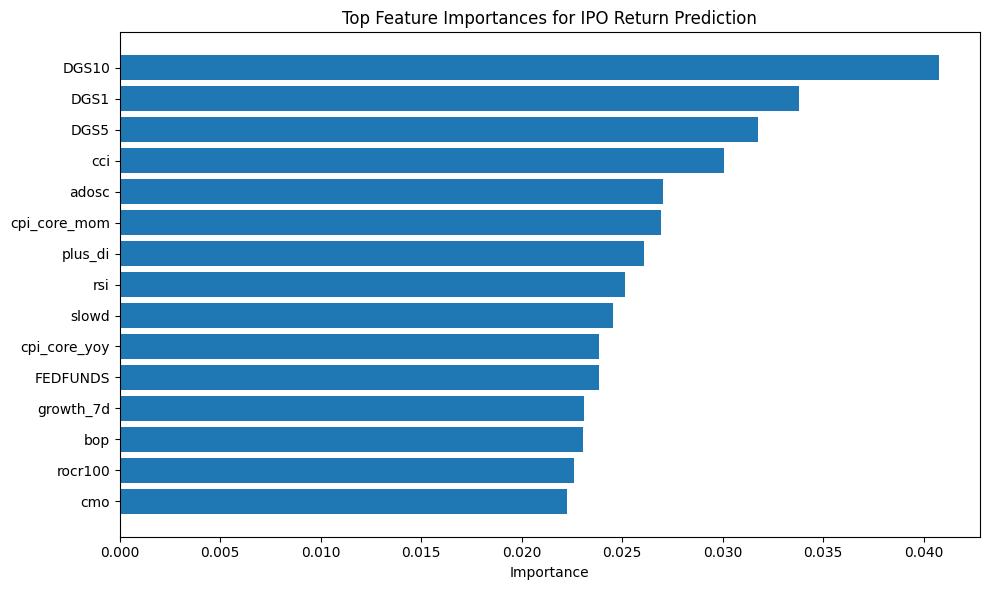

In [42]:
# Step 1: Drop target leakage + unneeded columns
drop_cols = [
    'Date', 'Ticker', 'Close_y', 'index_x', 'index_y', 'index',
    'growth_future_30d',  # remove regression target
]
df = selected_df.drop(columns=[col for col in drop_cols if col in selected_df.columns])

df = df.drop(columns=df.select_dtypes(include=['datetime64[ns]', 'object']).columns)
df = df.dropna(axis=1)

# Step 2: Define features and classification target
X = df.drop(columns=['is_positive_growth_30d_future'])
y = df['is_positive_growth_30d_future'].astype(int)

# Step 3: Handle missing values (drop or fill)
X = X.fillna(0)  # safer: impute or use KNN later

# Optional: normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# Step 5: Train classifier
clf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42)
clf.fit(X_train, y_train)

# Step 6: Evaluation
y_pred = clf.predict(X_test)

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("🔁 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Step 7: Feature importance
importances = clf.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importances)[-15:]  # top 15

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title("Top Feature Importances for IPO Return Prediction")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [43]:
X_test

array([[-0.40644774, -0.40682596, -0.40385329, ...,  0.04012398,
         0.87153146,  1.06394679],
       [-0.36750047, -0.36778788, -0.36439934, ...,  1.69026167,
         1.47420755,  1.26286057],
       [-0.33967967, -0.34081685, -0.33562971, ..., -0.45375526,
         0.24206977,  0.5737664 ],
       ...,
       [-0.40657237, -0.40694391, -0.40394195, ..., -0.0237898 ,
         0.55680062,  0.79399237],
       [-0.34240458, -0.34313809, -0.34401116, ..., -1.02316896,
        -0.96328241, -0.97491946],
       [-0.30694577, -0.30845504, -0.30220491, ...,  0.02850329,
         0.78447825,  1.01421834]], shape=(314, 116))

In [44]:
y_test

859     0
5082    0
430     0
3270    0
3994    1
       ..
2781    0
3858    0
1374    0
3544    1
509     0
Name: is_positive_growth_30d_future, Length: 314, dtype: int64

In [50]:
selected_df.loc[3544]['Ticker']

'HDB'